# plotting the p-mode power spectrum

In this notebook, we will be plotting a power spectrum of the p-modes using mean values of both full-disk Doppler velocity and continuum intensity data from the Helioseismic and Magnetic Imager instrument on NASA's Solar Dynamics Observatory (SDO). </br>

Some of this code is borrowed from Phil Scherrer's tutorial on making power spectra from Doppler velocity data and analyzing acoustic travel times through the Sun.

First, we'll import some modules.

In [1]:
import drms
import json, urllib, numpy as np, matplotlib.pylab as plt
from datetime import datetime as dt_obj
from matplotlib.dates import *
from math import pi
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Step 1: Plot the data

Grab two days of Doppler Velocity data:

In [2]:
c = drms.Client()

In [3]:
# keys_V = c.query('hmi.V_45s[2015.05.14_08:00_TAI/2d][? QUALITY=0 ?]', key='T_REC, OBS_VR, DATAMEA2')

Convert T_REC from a string to a datetime object:

In [4]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    second = int(tstr[17:19])
    if datetime: return dt_obj(year, month, day, hour, minute, second)
    else: return year,month,day,hour,minute,second

In [6]:
t_rec_V = np.array([parse_tai_string(keys_V.T_REC[i],datetime=True) for i in range(keys_V.T_REC.size)])

In [7]:
nrecs_V = keys_V.shape[0]

In [8]:
# subtract the radial component of the spacecraft's orbital velocity 
# from the Doppler Velocity data (both in units of m/s)

corrected_data_V = keys_V.DATAMEA2 - keys_V.OBS_VR

In [9]:
fig, ax = plt.subplots()

# ascribe the data to the axes
ax.plot(t_rec_V, corrected_data_V)

# format the x-axis with international atomic time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [24] # only show every day
formatter = DateFormatter('%d %b %Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('time in TAI starting at '+str(t_rec_V[0]))
ax.set_ylabel('DATAMEA2 - OBS_VR (m/s)')
ax.set_title('Raw Doppler Velocity data')

Grab four days of continuum intensity data:

In [9]:
keys_I = c.query('hmi.Ic_45s[2015.05.13_08:00_TAI/4d][? QUALITY=0 ?]', key='T_REC, OBS_VR, DATAMEA2')

In [10]:
t_rec_I = np.array([parse_tai_string(keys_I.T_REC[i],datetime=True) for i in range(keys_I.T_REC.size)])

In [11]:
nrecs_I = keys_I.shape[0]

In [12]:
# remove the effects of orbital velocity from the continuum intensity data
chunk = []
for i in range(1920, nrecs_I-1921, 1920):
    before_chunk = keys_I.DATAMEA2[i-1920:i]
    after_chunk = keys_I.DATAMEA2[i+1920:i+3840]
    avg_chunk = (before_chunk + after_chunk) / 2.0
    chunk.append(keys_I.DATAMEA2[i:i+1920] - avg_chunk)

Plot the continuum intensity data for the same date range as the Doppler velocity data:

In [13]:
t_start_index = np.where(t_rec_I == t_rec_V[0])[0][0]
t_end_index = np.where(t_rec_I == t_rec_V[-1])[0][0]

Text(0.5, 1.0, 'Raw Continuum Intensity Data')

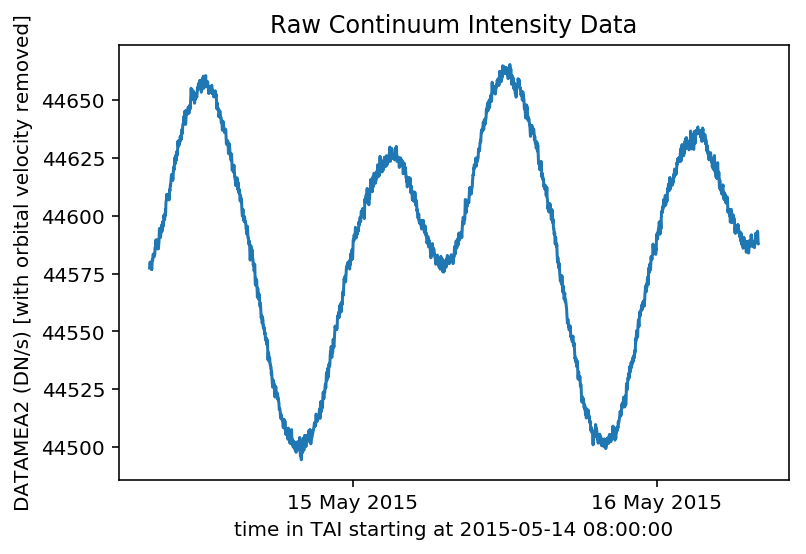

In [14]:
fig, ax = plt.subplots()

# ascribe the data to the axes
ax.plot(t_rec_I[t_start_index : t_end_index+1], keys_I.DATAMEA2[t_start_index : t_end_index+1])

# format the x-axis with international atomic time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [24] # only show every day
formatter = DateFormatter('%d %b %Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('time in TAI starting at '+str(t_rec_V[0]))
ax.set_ylabel('DATAMEA2 (DN/s) [with orbital velocity removed]')
ax.set_title('Raw Continuum Intensity Data')

### Step 2: Remove the low-frequency components

Perform a high pass filter by removing all the low-frequency components. The data spans 2 days so the step in frequency in the Fourier transform is 1/2d. Therefore, removing all power to 10/2d, 5/day, will remove the 12 and 24 hour oscillations and leave oscillations in the 5-minute range.

In [17]:
# zeroMean(thisArray) - sets the mean of the array to zero and replaces NaNs with 0.0    
def zeroMean(thisArray):
    avg = np.nanmean(thisArray)
    thisArray[np.isnan(thisArray)] = avg
    np.nan_to_num(thisArray)
    thisArray - avg
    return thisArray

In [16]:
final_V = zeroMean(corrected_data_V)
final_I = zeroMean(keys_I.DATAMEA2[t_start_index : t_end_index+1])

In [17]:
days = 2
filtf = 5 * days
x_V = np.fft.rfft(final_V)
x_V[0:filtf] = 0
y_V = np.fft.irfft(x_V)
y_V[len(y_V)-3:] = 0

Text(0.5, 1.0, 'Detrended Doppler Velocity data')

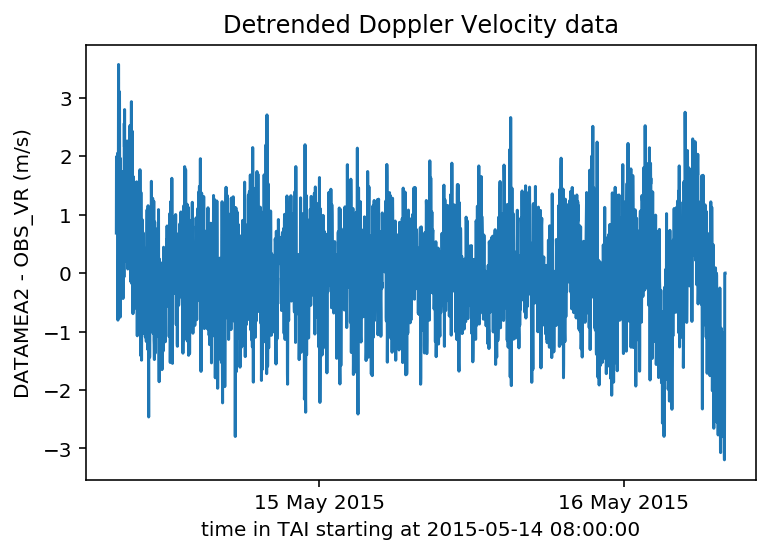

In [18]:
# plot the Doppler Velocity data

fig, ax = plt.subplots()

# ascribe the data to the axes
ax.plot(t_rec_V, y_V)

# format the x-axis with international atomic time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [24] # only show every day
formatter = DateFormatter('%d %b %Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('time in TAI starting at '+str(t_rec_V[0]))
ax.set_ylabel('DATAMEA2 - OBS_VR (m/s)')
ax.set_title('Detrended Doppler Velocity data')

In [19]:
x_I = np.fft.rfft(final_I)
x_I[0:filtf] = 0
y_I = np.fft.irfft(x_I)
y_I[len(y_I)-3:] = 0

Text(0.5, 1.0, 'Detrended Continuum Intensity Data')

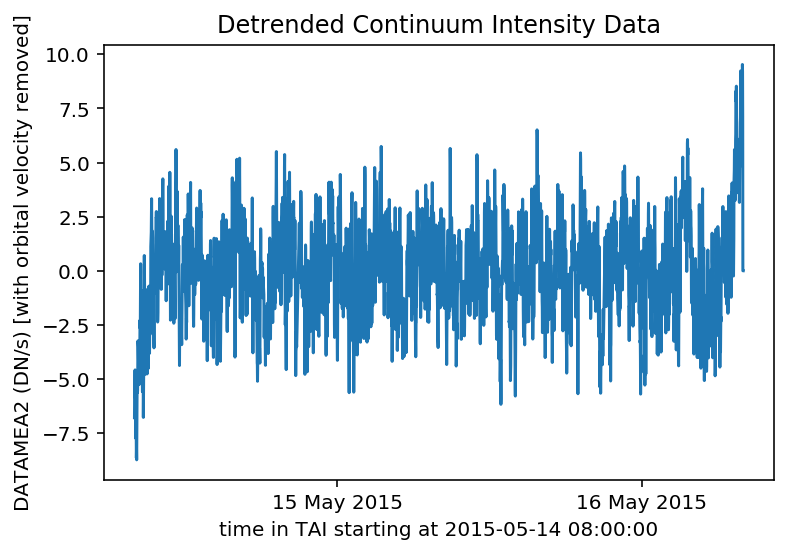

In [20]:
# plot the Continuum Intensity data

fig, ax = plt.subplots()

# ascribe the data to the axes
ax.plot(t_rec_I[t_start_index : t_end_index+1], y_I) 

# format the x-axis with international atomic time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [24] # only show every day
formatter = DateFormatter('%d %b %Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('time in TAI starting at '+str(t_rec_V[0]))
ax.set_ylabel('DATAMEA2 (DN/s) [with orbital velocity removed]')
ax.set_title('Detrended Continuum Intensity Data')

### Step 3: Compute the power spectrum of the filtered data

In [15]:
# the function below returns the power spectrum of real array data

def powSpec(thisData):
    data = np.array(thisData)
    averaged_data = zeroMean(data)
    fft = np.fft.rfft(averaged_data)
    powspec = fft * np.conj(fft)
    return np.real(powspec)

In [22]:
# Now compute power spectrum of the filtered Doppler Velocity data
ps_V = powSpec(y_V)

# Now compute power spectrum of the filtered continuum intensity data
ps_I = powSpec(y_I)

# We can zoom into the p-mode part of the spectrum
lowf = 150 * days
highf = 400 * days

# We can get an array of frequencies for the power spectrum
ifreqs = np.fft.rfftfreq(len(y_V),45) # len(y_V) equals len(y_I)

# Convert from Hertz to microHz
mfr = ifreqs * 1e6

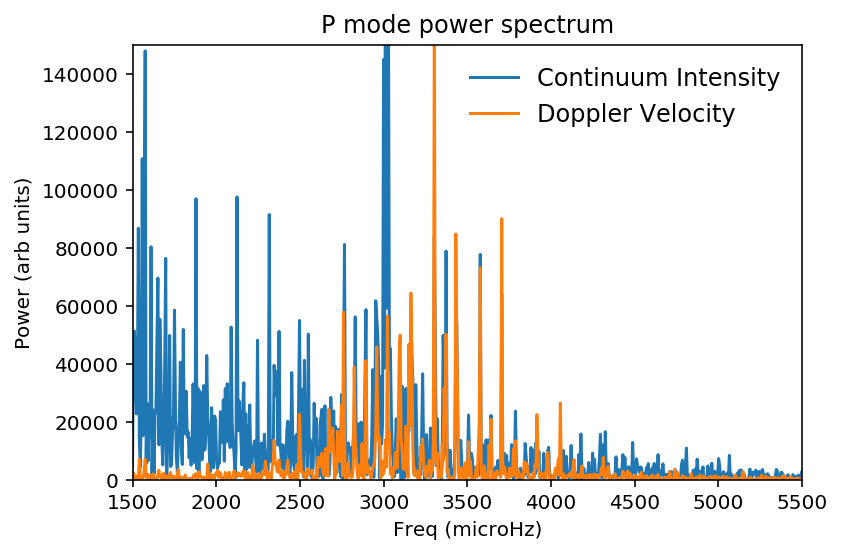

In [23]:
# Plot the p-mode power spectrum from the Doppler Velocity data 
# and the continuum intensity data

fig, ax = plt.subplots()

# ascribe the data to the axes
ax.plot(mfr, ps_I, label='Continuum Intensity')
ax.plot(mfr, ps_V, label='Doppler Velocity') 

# add some limits
plt.xlim(1500,5500)
plt.ylim(0,150000)

# label the axes, plot, and legend
ax.set_xlabel('Freq (microHz)')
ax.set_ylabel('Power (arb units)')
ax.set_title('P mode power spectrum')
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0,title='')
legend.get_frame().set_linewidth(0.0)

In [24]:
period_seconds = (1 / ifreqs)
period_minutes = period_seconds / 60.

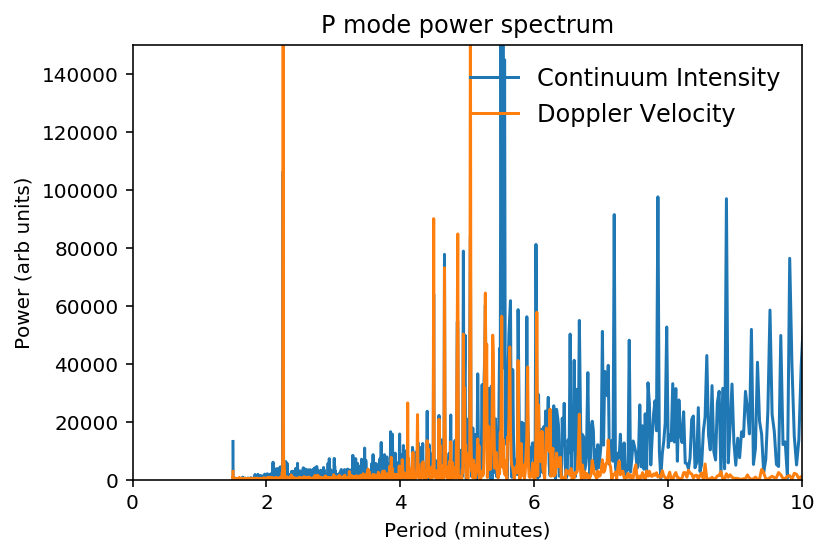

In [25]:
# Plot the p-mode power spectrum from the Doppler Velocity data 
# and the continuum intensity data

fig, ax = plt.subplots()

# ascribe the data to the axes
ax.plot(period_minutes, ps_I, label='Continuum Intensity')
ax.plot(period_minutes, ps_V, label='Doppler Velocity') 

# add some limits
plt.xlim(0,10)
plt.ylim(0,150000)

# label the axes, plot, and legend
ax.set_xlabel('Period (minutes)')
ax.set_ylabel('Power (arb units)')
ax.set_title('P mode power spectrum')
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0,title='')
legend.get_frame().set_linewidth(0.0)

***

# Reproducing the above power spectrum with Brett's detrended SDO continuum intensity photometry

In [11]:
t18, f18 = np.load('detrended_photometry2018.npy').T
t17, f17 = np.load('detrended_photometry2017.npy').T
t16, f16 = np.load('detrended_photometry2016.npy').T
t15, f15 = np.load('detrended_photometry2015.npy').T

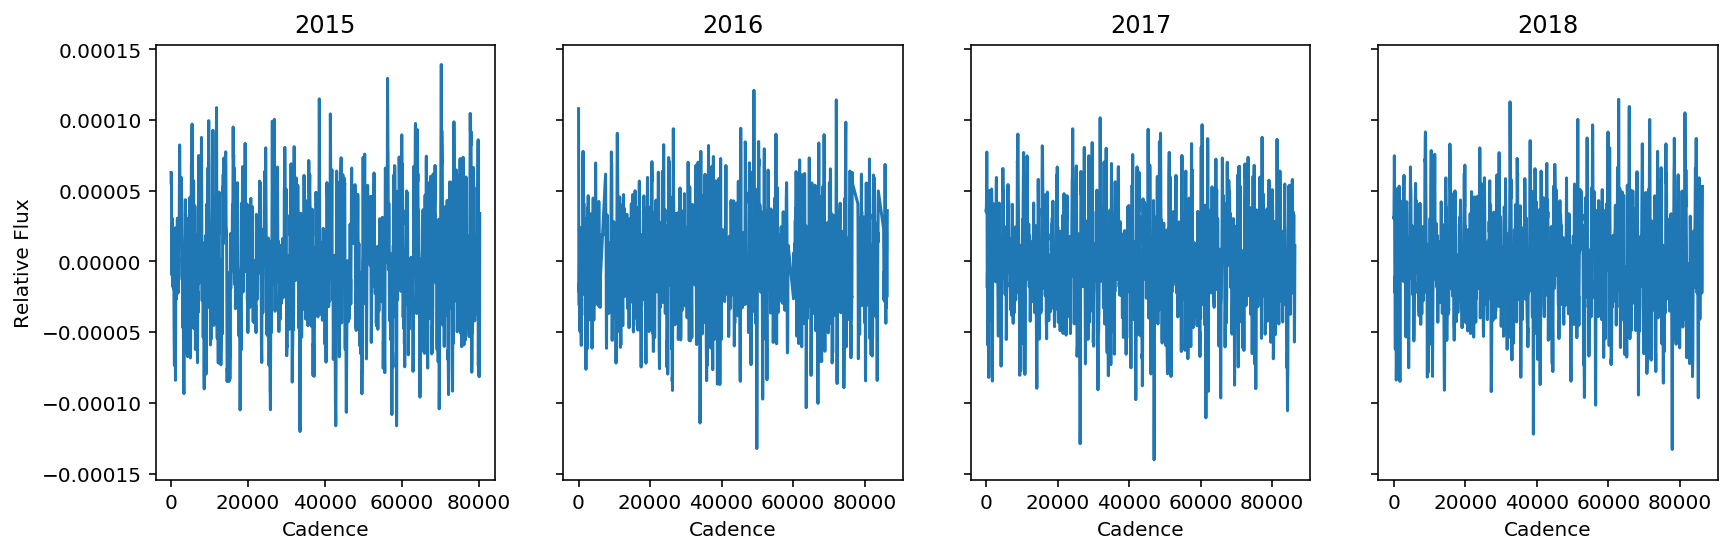

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
ax[0].plot(t15, f15)
ax[1].plot(t16, f16)
ax[2].plot(t17, f17)
ax[3].plot(t18, f18)

for axis, year in zip(ax, [2015, 2016, 2017, 2018]): 
    axis.set_title(year)
    axis.set_xlabel('Cadence')
ax[0].set_ylabel('Relative Flux')
plt.show()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


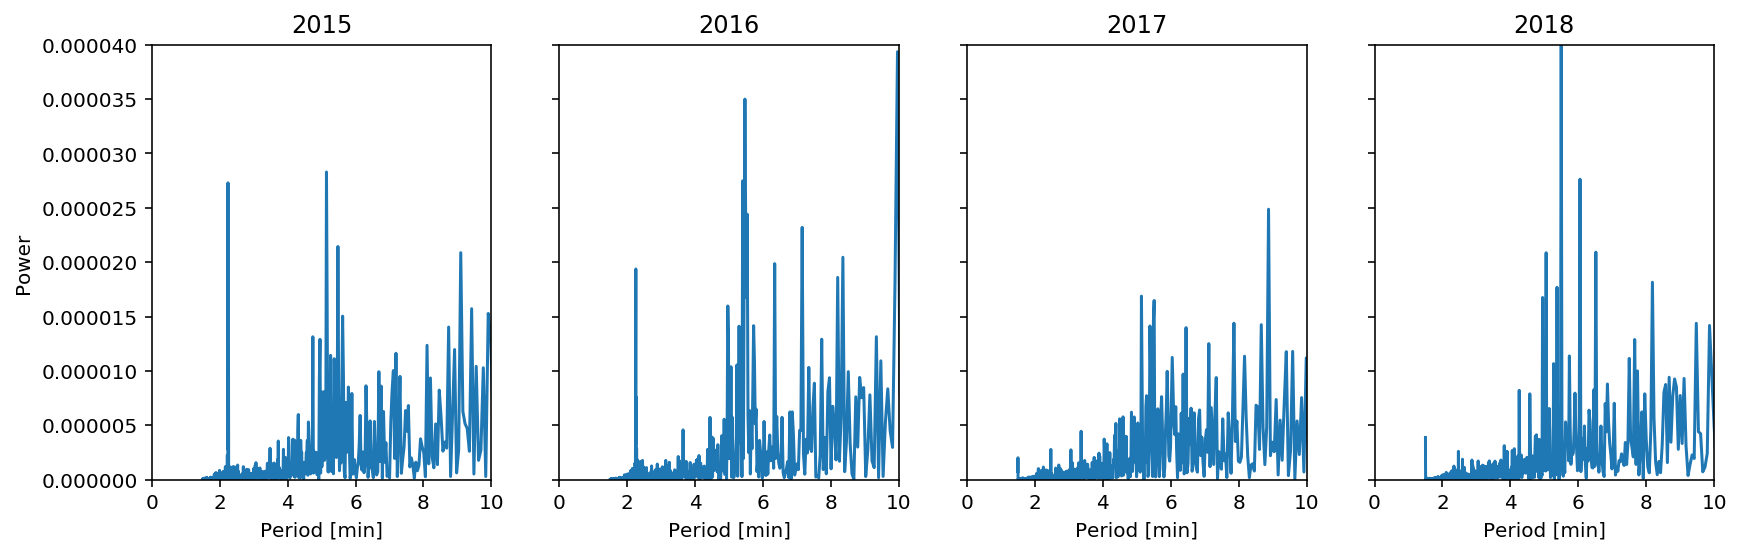

In [31]:
# We can get an array of frequencies for the power spectrum
ifreqs_15 = np.fft.rfftfreq(len(t15), 45)
ifreqs_16 = np.fft.rfftfreq(len(t16), 45)
ifreqs_17 = np.fft.rfftfreq(len(t17), 45)
ifreqs_18 = np.fft.rfftfreq(len(t18), 45)

power_15 = powSpec(f15)
power_16 = powSpec(f16)
power_17 = powSpec(f17)
power_18 = powSpec(f18)

period_seconds_15 = (1 / ifreqs_15)
period_seconds_16 = (1 / ifreqs_16)
period_seconds_17 = (1 / ifreqs_17)
period_seconds_18 = (1 / ifreqs_18)

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
ax[0].plot(period_seconds_15 / 60, power_15)
ax[1].plot(period_seconds_16 / 60, power_16)
ax[2].plot(period_seconds_17 / 60, power_17)
ax[3].plot(period_seconds_18 / 60, power_18)

for axis, year in zip(ax, [2015, 2016, 2017, 2018]): 
    axis.set_xlim([0, 10])
    axis.set_title(year)
    axis.set_ylim([0, 4e-5])
    axis.set_xlabel('Period [min]')
ax[0].set_ylabel('Power')
plt.show()